In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import gc

In [2]:
df = pd.read_csv('/Users/usuario/workspace/AMEX_data/train_data_LASSO_transformed.csv')

In [3]:
df

,Unnamed: 0,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_44,...,B_30_1.0,B_38_2.0,B_38_3.0,B_38_4.0,D_114_1.0,D_117_4.0,D_120_1.0,D_64_O,D_68_6.0,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,0.003258,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,0.008781,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.880859,0.009705,0.004284,0.812500,0.006451,0.164795,0.003796,0.007195,0.000628,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,0.007793,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.872070,0.005573,0.007679,0.815918,0.001247,0.164795,0.000231,0.005527,0.002436,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456642,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,0.844238,0.447510,0.028519,1.009766,0.001928,0.128662,0.003483,0.005894,0.002281,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
456643,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,0.831055,0.033661,0.292480,0.055664,0.006954,0.164795,0.005791,0.233032,0.132202,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
456644,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,0.800293,0.267090,0.020569,1.006836,0.000957,0.066650,0.007423,0.006313,0.001022,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
456645,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,0.753906,0.008621,0.015839,0.714355,0.000993,0.408936,0.003391,0.050049,0.133057,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1


In [4]:
%%time
# Conservamos el último registro de cada usuario
df =  (df
            .groupby('Unnamed: 0')
            .tail(1)
            .set_index('Unnamed: 0', drop=True)
            .sort_index())

CPU times: user 1.26 s, sys: 433 ms, total: 1.69 s
Wall time: 1.77 s


In [5]:
all_cols = df.columns.to_list()

cat_cols = [cname for cname in df.columns if df[cname].nunique() < 10 and 
                        df[cname].dtype == "object"]

num_cols = [col for col in all_cols if col not in cat_cols + ["target"]]

In [6]:
X = df[cat_cols + num_cols]
y = df['target']

X.shape, y.shape

((456647, 46), (456647,))

# Construimos las linea de base

## Partimos el conjunto de datos en train y test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

## Construimos el pipeline completo en tres pasos.

* Paso 1: definimos los pasos de preprocesamiento
De manera similar a el pipeline agrupa los pasos de preprocesamiento y modelado, usamos la clase ColumnTransformer para agrupar diferentes pasos de preprocesamiento. 

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

#El código a continuación imputa valores faltantes en datos numéricos, e
#imputa valores faltantes y aplica una codificación one-hot a los datos categóricos.

# Preprocesando la data numérica
numerical_transformer = SimpleImputer(strategy='median')

# Preprocesando la data categórica
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

* Paso 2: Definimos el modelo. En este caso para la linea de base utilizaremos una regresión logística

In [9]:
from sklearn.linear_model import LogisticRegression
semilla = 1234
model = LogisticRegression(random_state=semilla, max_iter=200, solver="saga")

* Paso 3: crear y evaluar el pipeline
Finalmente, usamos la clase Pipeline para definir un pipeline que agrupa los pasos de preprocesamiento y modelado. Hay algunas cosas importantes a tener en cuenta:

Con el pipeline, preprocesamos los datos de entrenamiento y ajustamos el modelo en una sola línea de código. (Por el contrario, sin un pipeline, tendríamos que hacer la imputación, la codificación one-hot y el entrenamiento del modelo en pasos separados.

Con el pipeline proporcionamos las funciones no procesadas en X_test al comando predict(), y el pipeline preprocesa automáticamente las funciones antes de generar predicciones. (Sin embargo, sin el pipeline, debemos recordar preprocesar los datos de validación antes de hacer predicciones).

In [10]:
# Paquete de preprocesamiento y código de modelado
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)
                             ])

# Preprocesamiento de datos de entrenamiento, ajuste del modelo
my_pipeline.fit(X_train, y_train)

# Preprocesamiento de datos de validación, obtener predicciones
preds = my_pipeline.predict(X_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,preds)
print(cm)
print(f'El accuracy score para el modelo base es: {accuracy_score(y_test, preds)}')

[[79134  5443]
 [ 7676 21909]]
El accuracy score para el modelo base es: 0.8850843538130025


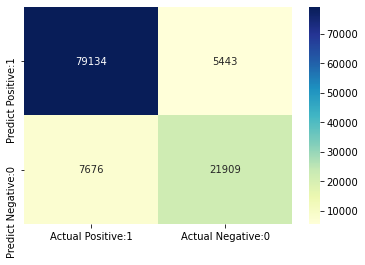

In [12]:
import seaborn as sns
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                        index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92     84577
           1       0.80      0.74      0.77     29585

    accuracy                           0.89    114162
   macro avg       0.86      0.84      0.85    114162
weighted avg       0.88      0.89      0.88    114162



## Probamos otros modelos
Probaremos una serie de modelos con sus parametros por defecto, sin tuning:

* Decision tree: un árbol de decisión.

* Extra trees: Un clasificador de árboles adicionales. Esta clase implementa un meta estimador que se ajusta a una serie de árboles de decisión aleatorios en varias submuestras del conjunto de datos, y utiliza el promedio para mejorar la precisión predictiva y controlar el ajuste excesivo.

* Random Forest: Un Random Forest es un conjunto (ensemble) de árboles de decisión combinados con bagging. Es una combinación de árboles predictores tal que cada árbol depende de los valores de un vector aleatorio probado independientemente y con la misma distribución para cada uno de estos.

* AdaBoost: consiste en crear varios predictores sencillos en secuencia, de tal manera que el segundo ajuste bien lo que el primero no ajustó, que el tercero ajuste un poco mejor lo que el segundo no pudo ajustar y así sucesivamente.

* GradientBoosting: es una técnica de aprendizaje automático utilizado para el análisis de la regresión y para problemas de clasificación estadística, el cual produce un modelo predictivo en forma de un conjunto de modelos de predicción débiles, típicamente árboles de decisión. Construye el modelo de forma escalonada como lo hacen otros métodos de boosting, y los generaliza permitiendo la optimización arbitraria de una función de pérdida diferenciable.



In [14]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_openml
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

In [15]:
clasificador_tree_ = DecisionTreeClassifier(random_state=semilla)
clasificador_random_forest = RandomForestClassifier(n_estimators=100, random_state=semilla)
clasificador_extra_trees = ExtraTreesClassifier(n_estimators=100, random_state=semilla)
clasificador_adaboost = AdaBoostClassifier(random_state=semilla)
clasificador_gradientboost = GradientBoostingClassifier(random_state=semilla)

In [16]:
clasificadores = [clasificador_tree_, clasificador_random_forest, clasificador_extra_trees, 
                clasificador_adaboost, clasificador_gradientboost]

In [17]:
%%time
for clasificador in clasificadores:
    print(f'Entrenando el modelo {clasificador}')
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', clasificador)
                              ])

    # Preprocesamiento de datos de entrenamiento, ajuste del modelo
    my_pipeline.fit(X_train, y_train)
    # Preprocesamiento de datos de validación, obtener predicciones
    preds = my_pipeline.predict(X_test)
    # Calculamos la matriz de confusión
    cmx = confusion_matrix(y_test,preds)
    # Mostramos las métricas de evaluación
    print(classification_report(y_test, preds)+'\n')
    print('Matriz de confusión:\n') 
    print(cmx)
    print('\n') 

Entrenando el modelo DecisionTreeClassifier(random_state=1234)
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     84577
           1       0.70      0.70      0.70     29585

    accuracy                           0.84    114162
   macro avg       0.80      0.80      0.80    114162
weighted avg       0.84      0.84      0.84    114162


Matriz de confusión:

[[75669  8908]
 [ 9000 20585]]


Entrenando el modelo RandomForestClassifier(random_state=1234)
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     84577
           1       0.79      0.78      0.79     29585

    accuracy                           0.89    114162
   macro avg       0.86      0.86      0.86    114162
weighted avg       0.89      0.89      0.89    114162


Matriz de confusión:

[[78554  6023]
 [ 6450 23135]]


Entrenando el modelo ExtraTreesClassifier(random_state=1234)
              precision    recall  f1-score   s